# Study case: is the performance of a team related with the population of the metropolitan area where it is based?

In this notebook I will try to answer the following two questions:
1. Is there a correlation between a team's performance and the population of the metropolitan area where it is based?
2. Do teams of different sports based in the same metropolitan area have a similar performance?

For this, I will be using the american football (NFL), baseball (MLB), basketball (NBA) and ice hockey (NHL) leagues from North America. This choice was made considering data availability and the fact that many metropolitan areas have teams competing in more than one of the four major leagues, which is key in trying to answer the second question. The information used is from the regular seasons of each league from 2021-2022. The populations of each metropolitan area where each team is based is an estimation made in 2016 by _Demographia_, in the ["Demographia World Urban Areas – 12th Annual Edition"](https://web.archive.org/web/20170110105739/http://www.demographia.com/db-worldua.pdf).

Before starting, I will point out a few relevant things on how the _performance_ of a team will be measured, and about the datasets used as a starting point. Regarding the _performance_ of a team, this was measured as a **win to loss ratio**. In particular, it will be calculated as follows:

$$ performance = \frac{wins}{wins + losses}$$

In the case where a metropolitan area has more than one team competing in the same major league, their performances will be averaged.

Regarding **question 1**, the first attempt to answer this will be with a simple *Pearson's R* correlation factor, as in a linear regression. If this does not answer the question, further plotting and data analysis might be carried out.
Regarding **question 2**, this will be done with *relational t-tests* between the performance of each pair of sports, with a significance level of 95%.

---
## Data cleaning

In this section I will extract and clean the data needed for this analysis. To begin with, below there are the needed libraries and packages.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import re

### The metropolitan area, population and sports dataset

Firstly, I used the table found in [this wikipedia entry](https://en.wikipedia.org/wiki/List_of_American_and_Canadian_cities_by_number_of_major_professional_sports_franchises) as a starting point to create a data set that contains Metropolitan area, Population (estimated from 2016), and the teams of each of the *Big 4* (NFL, MLB, NBA and NHL). In the cell below, you can see the data cleaning of this html file to get a dataframe that contains lists of teams of each of the Big 4, so I also take into account the cities that have more than one team playing in one of the major leagues.

In [2]:
cities_html = "data/cities.html"
cities = pd.read_html(cities_html)[1].iloc[:-1, [0, 3, 5, 6, 7, 8]]
cities.rename({"Population (2016 est.)[8]": "Population"}, axis=1, inplace=True)

def clean_teams(string):
    pattern = "(.*)(?=\[.*\])?"
    return re.findall("([A-Z][a-z]*)+?", re.search(pattern, string)[0])

for sport in cities.columns[2:]:
    cities[sport] = cities[sport].apply(clean_teams)
cities.loc[6]["NFL"] = list(["49ers"])
cities.loc[17]["NBA"] = list(["76ers"])
cities.head()

,Metropolitan area,Population,NFL,MLB,NBA,NHL
0,Winnipeg,778489,[],[],[],[Jets]
1,"Washington, D.C.",6131977,[Commanders],[Nationals],[Wizards],[Capitals]
2,Vancouver,2463431,[],[],[],[Canucks]
3,Toronto,5928040,[],"[Blue, Jays]",[Raptors],"[Maple, Leafs]"
4,Tampa Bay Area,3032171,[Buccaneers],[Rays],[],[Lightning]


### The NFL, MLB, NBA and NHL datasets


Now is the turn to extract and clean the datasets of teams of each of the four leagues, and the wins and losses in each case. These can be found in the following wikipedia entries from the seasons of 2021-2022: [NFL](https://en.wikipedia.org/wiki/2021_NFL_season), [MLB](https://en.wikipedia.org/wiki/2021_Major_League_Baseball_season), [NBA](https://en.wikipedia.org/wiki/2021%E2%80%9322_NBA_season), [NHL](https://en.wikipedia.org/wiki/2021%E2%80%9322_NHL_season).

In all four cases, the relevant information comes divided into several tables, depending on the league or division, for example. After selecting the corresponding tables though, the data cleaning process is fairly similar, in particular for the NFL, MLB and NBA leagues. Because of this,I will use two general functions that are defined below.

In [3]:
def team_w_l(frames):
    """
    Takes a list of pandas dataframes of one of the Big 4 teams season and returns a single 
    pandas dataframe with all the teams, the wins and the loses.
    """
    cleaned_frames = []
    for frame in frames:
        to_append = frame
        if type(frame.columns[0]) == tuple:
            to_append = frame.droplevel(0, axis=1)
            
        to_append.rename(columns={to_append.columns[0]: "TEAM"}, inplace=True)
        cleaned_frames.append(to_append)
        
    return pd.concat(cleaned_frames).reset_index().iloc[:, [1, 2, 3]]

def clean_teams_w_l(string):
    """
    Cleans team names in the team-win-loss dataframe of each sport.
    Since the MLB league has the Red Sox and the White Sox playing, I handle that only
    exception manually.
    """
    pattern = "(\(\d\)\s)?(.+)"
    if re.match(pattern, string)[2].split()[-1] == "Sox":
        return re.match(pattern, string)[2].split()[-2]
    return re.match(pattern, string)[2].split()[-1]

Here I used the previously defined functions to obtain the NFL teams dataset as below:

In [4]:
nfl_frames = pd.read_html("data/nfl2021.html")[4:12]
nfl2021 = team_w_l(nfl_frames)
nfl2021["TEAM"] = nfl2021["TEAM"].apply(clean_teams_w_l).replace({"Team": "Commanders"})
nfl2021.head()

,TEAM,W,L
0,Bills,11,6
1,Patriots,10,7
2,Dolphins,9,8
3,Jets,4,13
4,Bengals,10,7


In a very similar way, to create the MLB teams dataset:

In [5]:
mlb_frames = pd.read_html("data/mlb2021.html")[2:8]    
mlb2021 = team_w_l(mlb_frames)
mlb2021["TEAM"] = mlb2021["TEAM"].apply(clean_teams_w_l).replace({"Indians": "Guardians"})
mlb2021.head()

,TEAM,W,L
0,Rays,100,62
1,Red,92,70
2,Yankees,92,70
3,Jays,91,71
4,Orioles,52,110


And to obtain the NBA teams dataset:

In [6]:
nba_frames = pd.read_html("data/nba2021.html")[3:9]    
nba2021 = team_w_l(nba_frames)
nba2021["TEAM"] = nba2021["TEAM"].apply(clean_teams_w_l)
nba2021.head()

,TEAM,W,L
0,Celtics,51,31
1,76ers,51,31
2,Raptors,48,34
3,Nets,44,38
4,Knicks,37,45


In the case of the NHL teams, since the data was provided in the wikipedia entry in a slightly different manner, the functions `team_w_l` and `clean_teams_w_l` are not helpful and I generate the dataset with the code below:

In [7]:
nhl_frames = pd.read_html("data/nhl2021.html")[3:9]    
cleaned_frames = []
for frame in nhl_frames:
    to_append = frame

    to_append.rename(columns={to_append.columns[1]: "TEAM"}, inplace=True)
    cleaned_frames.append(to_append)

nhl2021 = pd.concat(cleaned_frames).reset_index()
nhl2021["Team v t e"].fillna(0, inplace=True)
nhl2021.loc[nhl2021["Team v t e"] != 0, "TEAM"] = nhl2021["Team v t e"]
nhl2021 = nhl2021.dropna().iloc[:, [2, 4, 5]]
nhl2021["TEAM"] = nhl2021["TEAM"].apply(lambda x: x.split()[-1])
nhl2021.head()

,TEAM,W,L
0,Hurricanes,54.0,20.0
1,Rangers,52.0,24.0
2,Penguins,46.0,25.0
3,Panthers,58.0,18.0
4,Leafs,54.0,21.0


---
## Data processing

To calculate the performance of each team, I merged the `cities` dataset with each of the four datasets of each team from above. This is done separately, to then calcular the ratio wins-losses, included in the new dataset. In case a metropolitan area has more than one team in the same league, averaged. This data processing is done below for the four leagues.

### NFL Performance

In [8]:
cities_nfl = (cities.drop(["MLB", "NBA", "NHL"], axis=1)
              .set_index(["Metropolitan area", "Population"])
              .apply(lambda x: x.explode())
              .reset_index()
              .rename({"NFL": "TEAM"}, axis=1))
cities_nfl = pd.merge(cities_nfl, nfl2021, how="left", on="TEAM").dropna()

cities_nfl["W"] = cities_nfl["W"].apply(lambda x: int(x))
cities_nfl["L"] = cities_nfl["L"].apply(lambda x: int(x))
cities_nfl["Population"] = cities_nfl["Population"].apply(lambda x: int(x))
cities_nfl["win/loss"] = cities_nfl["W"] / (cities_nfl["W"] + cities_nfl["L"])
cities_nfl = (cities_nfl.groupby(["Metropolitan area", "Population"])
            .agg({"TEAM": lambda x: x.tolist(), "W": lambda x: x.tolist(), "L": lambda x: x.tolist(), "win/loss": "mean"})
            .rename({"win/loss": "Avg win/loss"}, axis=1)
            .reset_index())
cities_nfl.head()

,Metropolitan area,Population,TEAM,W,L,Avg win/loss
0,Atlanta,5789700,[Falcons],[7],[10],0.411765
1,Baltimore,2798886,[Ravens],[8],[9],0.470588
2,Boston,4794447,[Patriots],[10],[7],0.588235
3,Buffalo,1132804,[Bills],[11],[6],0.647059
4,Charlotte,2474314,[Panthers],[5],[12],0.294118


### MLB Performance

In [9]:
cities_mlb = (cities.drop(["NFL", "NBA", "NHL"], axis=1)
              .set_index(["Metropolitan area", "Population"])
              .apply(lambda x: x.explode())
              .reset_index()
              .rename({"MLB": "TEAM"}, axis=1))
cities_mlb = pd.merge(cities_mlb, mlb2021, how="left", on="TEAM").dropna()

cities_mlb["W"] = cities_mlb["W"].apply(lambda x: int(x))
cities_mlb["L"] = cities_mlb["L"].apply(lambda x: int(x))
cities_mlb["Population"] = cities_mlb["Population"].apply(lambda x: int(x))
cities_mlb["win/loss"] = cities_mlb["W"] / (cities_mlb["W"] + cities_mlb["L"])

cities_mlb = (cities_mlb.groupby(["Metropolitan area", "Population"])
            .agg({"TEAM": lambda x: x.tolist(), "W": lambda x: x.tolist(), "L": lambda x: x.tolist(), "win/loss": "mean"})
            .rename({"win/loss": "Avg win/loss"}, axis=1)
            .reset_index())
cities_mlb.head()

,Metropolitan area,Population,TEAM,W,L,Avg win/loss
0,Atlanta,5789700,[Braves],[88],[73],0.546584
1,Baltimore,2798886,[Orioles],[52],[110],0.320988
2,Boston,4794447,[Red],[92],[70],0.567901
3,Chicago,9512999,"[Cubs, White]","[71, 93]","[91, 69]",0.506173
4,Cincinnati,2165139,[Reds],[83],[79],0.512346


### NBA Performance

In [10]:
cities_nba = (cities.drop(["NFL", "MLB", "NHL"], axis=1)
              .set_index(["Metropolitan area", "Population"])
              .apply(lambda x: x.explode())
              .reset_index()
              .rename({"NBA": "TEAM"}, axis=1))
cities_nba = pd.merge(cities_nba, nba2021, how="left", on="TEAM").dropna()

cities_nba["W"] = cities_nba["W"].apply(lambda x: int(x))
cities_nba["L"] = cities_nba["L"].apply(lambda x: int(x))
cities_nba["Population"] = cities_nba["Population"].apply(lambda x: int(x))
cities_nba["win/loss"] = cities_nba["W"] / (cities_nba["W"] + cities_nba["L"])

cities_nba = (cities_nba.groupby(["Metropolitan area", "Population"])
            .agg({"TEAM": lambda x: x.tolist(), "W": lambda x: x.tolist(), "L": lambda x: x.tolist(), "win/loss": "mean"})
            .rename({"win/loss": "Avg win/loss"}, axis=1)
            .reset_index())
cities_nba.head()

,Metropolitan area,Population,TEAM,W,L,Avg win/loss
0,Atlanta,5789700,[Hawks],[43],[39],0.524390
1,Boston,4794447,[Celtics],[51],[31],0.621951
2,Charlotte,2474314,[Hornets],[43],[39],0.524390
3,Chicago,9512999,[Bulls],[46],[36],0.560976
4,Cleveland,2055612,[Cavaliers],[44],[38],0.536585


### NHL Performance

In [11]:
cities_nhl = (cities.drop(["NFL", "MLB", "NBA"], axis=1)
              .set_index(["Metropolitan area", "Population"])
              .apply(lambda x: x.explode())
              .reset_index()
              .rename({"NHL": "TEAM"}, axis=1))
cities_nhl = pd.merge(cities_nhl, nhl2021, how="left", on="TEAM").dropna()

cities_nhl["W"] = cities_nhl["W"].apply(lambda x: int(x))
cities_nhl["L"] = cities_nhl["L"].apply(lambda x: int(x))
cities_nhl["Population"] = cities_nhl["Population"].apply(lambda x: int(x))
cities_nhl["win/loss"] = cities_nhl["W"] / (cities_nhl["W"] + cities_nhl["L"])

cities_nhl = (cities_nhl.groupby(["Metropolitan area", "Population"])
            .agg({"TEAM": lambda x: x.tolist(), "W": lambda x: x.tolist(), "L": lambda x: x.tolist(), "win/loss": "mean"})
            .rename({"win/loss": "Avg win/loss"}, axis=1)
            .reset_index())
cities_nhl.head()

,Metropolitan area,Population,TEAM,W,L,Avg win/loss
0,Boston,4794447,[Bruins],[51],[26],0.662338
1,Buffalo,1132804,[Sabres],[32],[39],0.450704
2,Calgary,1392609,[Flames],[50],[21],0.704225
3,Chicago,9512999,[Blackhawks],[28],[42],0.400000
4,Columbus,2041520,[Jackets],[37],[38],0.493333


---
## Data analysis

Now both initial questions will be adressed. Firstly, the correlation between each team performance and the population of the area where the team is based. Secondly, the similarity in performance of teams of different sports based in the same metropolitan area.

### 1. The correlation between team performance and area's population

The first attempt to calculate the correlation between two datasets is the *Pearson's R squared correlation coefficient*, commonly known as $R^2$.

In [12]:
for league, df in {"NFL": cities_nfl, "MLB": cities_mlb, "NBA": cities_nba, "NHL": cities_nhl}.items():
    print("For", league, "-", stats.pearsonr(df["Population"], df["Avg win/loss"])[0]**2)

For NFL - 0.08661548858974036
For MLB - 0.02160101193462449
For NBA - 0.009088639900681197
For NHL - 0.027856845116716503


The closest the $R^2$ is to a unit value, the stronger the correlation between the two datasets. The values above clearly show that there is barely any correlation at all. To confirm this, I made scatter plots of each of the four league teams against the population of the area where they are based.

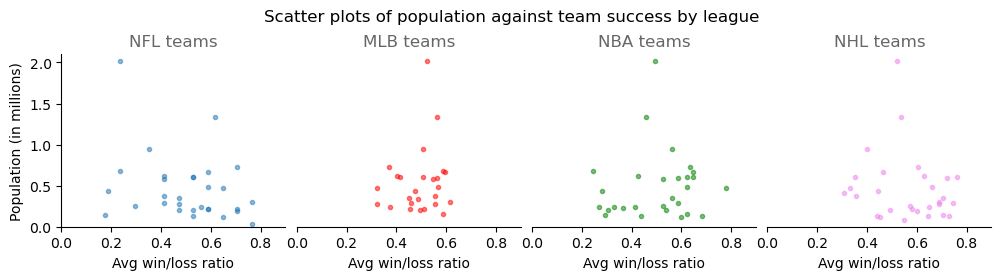

In [13]:
fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, sharey=True, figsize=(12,2.5))
fig.suptitle("Scatter plots of population against team success by league")
plt.subplots_adjust(wspace=0.05, top=0.8)
ax1.scatter(cities_nfl["Avg win/loss"], cities_nfl["Population"]/1e7, marker=".", alpha=0.5)
ax1.set_title("NFL teams", alpha=0.6)
ax1.set_xlabel("Avg win/loss ratio")
ax1.set_ylabel("Population (in millions)")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.axis([0, 0.9, 0, 2.1])

ax2.scatter(cities_mlb["Avg win/loss"], cities_mlb["Population"]/1e7, marker=".", color="r", alpha=0.5)
ax2.set_title("MLB teams", alpha=0.6)

ax3.scatter(cities_nba["Avg win/loss"], cities_nba["Population"]/1e7, marker=".", color="green", alpha=0.5)
ax3.set_title("NBA teams", alpha=0.6)

ax4.scatter(cities_nhl["Avg win/loss"], cities_nhl["Population"]/1e7, marker=".", color="violet", alpha=0.5)
ax4.set_title("NHL teams", alpha=0.6)

for ax in [ax2, ax3, ax4]:
    ax.axis([0, 0.9, 0, 2.1])
    ax.set_xlabel("Avg win/loss ratio")
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(axis="y", length=0)

These four scatter plots show much more clearly that there is not any evident correlation between the performance of a team and the population of the metropolitan area where it is based. In fact, one could argue that, for all four leagues, the performance of the teams is centered around 0.5 and scattered to both sides a fair bit, independantly of the population.

### 2. The similarity in performance in teams of different sports from the same metropolitan area

Here I will address the second question stated initially in this work. The objective is to compare the *success* of teams of different sports that are based in the same metropolitan area. Again, in the case in which one metropolitan area has more than one team of the same sport, their performances will be average. For this, first I created a dataset with performances of all teams per metropolitan area:

In [14]:
nfls = (cities_nfl.rename({"TEAM": "NFL", "Avg win/loss": "Avg win/loss NFL"}, axis=1)
        .drop(["Population", "W", "L", "NFL"], axis=1))
mlbs = (cities_mlb.rename({"TEAM": "MLB", "Avg win/loss": "Avg win/loss MLB"}, axis=1)
        .drop(["Population", "W", "L", "MLB"], axis=1))
nbas = (cities_nba.rename({"TEAM": "NBA", "Avg win/loss": "Avg win/loss NBA"}, axis=1)
        .drop(["Population", "W", "L", "NBA"], axis=1))
nhls = (cities_nhl.rename({"TEAM": "NHL", "Avg win/loss": "Avg win/loss NHL"}, axis=1)
        .drop(["Population", "W", "L", "NHL"], axis=1))

area_sports = pd.merge(nfls, mlbs, how="outer", on="Metropolitan area")
area_sports = pd.merge(area_sports, nbas, how="outer", on="Metropolitan area")
area_sports = pd.merge(area_sports, nhls, how="outer", on="Metropolitan area")

area_sports.head()

,Metropolitan area,Avg win/loss NFL,Avg win/loss MLB,Avg win/loss NBA,Avg win/loss NHL
0,Atlanta,0.411765,0.546584,0.524390,NaN
1,Baltimore,0.470588,0.320988,NaN,NaN
2,Boston,0.588235,0.567901,0.621951,0.662338
3,Buffalo,0.647059,NaN,NaN,0.450704
4,Charlotte,0.294118,NaN,0.524390,NaN


In the case where a metropolitan area has only teams in one of the four leagues, this will not be considered since they can not be compared to any other. To account for the *similarity* between two series of data (i.e. performance of NFL teams and performance of MLB teams) a **relational t-test** was performed, with a significance level of $\alpha = 0.05$ and the values obtained for each pair of sports are shown below.
A t-test returns a value called *p-value*, that either rejects or does not reject the initial hypothesis. In these cases, the hypotheses are:
1. $H_0$, initial hypothesis: both performances compared are the same.
2. $H_1$, alternative hypothesis: both performances compared are different.

The $H_0$ hypothesis is rejected if $p-value < \alpha$, and not rejected otherwise.
Since all leagues teams performance will be compared with the other three, the output is several *p-values*, one for each comparison. This is shown in a table below.

In [15]:
p_vals = {}
for idx1 in area_sports.columns[1:]:
    p_vals[idx1] = []
    for idx2 in area_sports.columns[1:]:
        df = area_sports[[idx1, idx2]].dropna()
        _, pval = stats.ttest_rel(df[idx1], df[idx2])
        if idx1 == idx2:
            p_vals[idx1].append(np.nan)
        else:
            p_vals[idx1].append(pval)

p_values = (pd.DataFrame(p_vals, index=["NFL", "MLB", "NBA", "NHL"])
            .rename({key:value for key,value in zip(area_sports.columns[1:], ["NFL", "MLB", "NBA", "NHL"])}, axis=1))

p_values

,NFL,MLB,NBA,NHL
NFL,NaN,0.755328,0.054331,0.522869
MLB,0.755328,NaN,0.238211,0.059440
NBA,0.054331,0.238211,NaN,0.983097
NHL,0.522869,0.059440,0.983097,NaN


This table has to be interpreted as follows:
1. Values are duplicated, where NFL-MLB value = MLB-NFL value.
2. The diagonal is irrelevant, because a sport can not be compared with itself.
3. The values in the table are the *p-values* of each t-test. In particular, $p-value < 0.05$ means that, with 95% of confidence, there is a correlation between the performance of each value.

With these three bullet points in mind, it is concluded that there is not sufficient evidence to reject the hypothesis $H_0$, that teams of different sports based in the same metropolitan area perform the same.